# Socioeconomic data and TOC entitlements
* Entitlements assigned to census tracts
* Which census tracts (what income levels or median household income) have seen TOC entitlements?
* See if tract is composed of mostly TOC-eligible parcels
* Then look at Census characteristics of mostly TOC-eligible tracts vs not

In [1]:
import boto3
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pcts_census_utils
import utils

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## A1. Identify this dichotomy of tracts that are mostly TOC-eligible vs not

In [3]:
def toc_tracts_clean_and_aggregate():
    # Import data
    crosswalk_parcels_tracts = pd.read_parquet(f's3://{bucket_name}/data/crosswalk_parcels_tracts.parquet')

    s3.download_file(bucket_name, f'gis/intermediate/TOC_Parcels.parquet', '../gis/TOC_Parcels.parquet')
    toc_parcels = gpd.read_parquet('../gis/TOC_Parcels.parquet')
    os.remove('../gis/TOC_Parcels.parquet')

    df = pd.merge(crosswalk_parcels_tracts.drop(columns = "pop"), 
         toc_parcels[toc_parcels.TOC_Tier > 0].drop(columns = 'TOC_Tier'), 
         on = 'AIN', how = 'left', validate = '1:1')
    
    # Get rid of duplicate AIN's
    df = df[df.num_AIN == 1]
    
    # Tag if the parcel counts as in TOC tier or not
    def in_tier(row):
        if row.TOC_Tier != 0:
            return 1
        elif row.TOC_Tier == 0:
            return 0

    df = df.assign(
        in_tier = df.apply(in_tier, axis=1)
    )
    
    # Aggregate by in_tier 
    df = (df.groupby(["GEOID", "parcel_tot", "in_tier"])
          .agg({"num_AIN": "sum",
               "parcelsqft":"sum"})
          .reset_index()
         )
    
    # If GEOID has 2 observations, one in_tier==1 and other in_tier==0, let's keep the in_tier==1
    df["obs"] = df.groupby("GEOID").cumcount() + 1
    df["max_obs"] = df.groupby("GEOID")["obs"].transform("max")
    
    df = (df[(df.max_obs == 1) | 
             ((df.in_tier == 1) & (df.max_obs == 2))]
          .drop(columns = ["obs", "max_obs"])
         )
    
    
    # Also, count the total of AIN within each tract
    total_AIN = (crosswalk_parcels_tracts[crosswalk_parcels_tracts.num_AIN == 1]
                    .groupby(['GEOID'])
                    .agg({'num_AIN':'sum'})
                    .rename(columns = {'num_AIN':'total_AIN'})
                    .reset_index()
                   )
    
    # Merge together 
    df2 = pd.merge(df, total_AIN, on = 'GEOID', how = 'left', validate = 'm:1')
    
    # Calculate the % of AIN that falls within TOC tiers and % of area within TOC tiers
    df2 = (df2.assign(
            pct_AIN = df2.num_AIN / df2.total_AIN,
            pct_area = df2.parcelsqft / df2.parcel_tot,
        ).sort_values("GEOID")
           .reset_index(drop=True)
    )
    
    return df2

In [4]:
df = toc_tracts_clean_and_aggregate()

## A2. Merge in number of TOC entitlements that tract had

In [5]:
# Download parcels with TOC entitlement info, and only keep parcels with TOC ent
def tracts_with_TOC_ent():    
    parcels = gpd.read_file(
        f"s3://{bucket_name}/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
    ).to_crs('EPSG:4326')

    toc_parcels = parcels[parcels.num_TOC > 0][['AIN', 'num_TOC', 'num_nonTOC']]

    crosswalk_parcels_tracts = pd.read_parquet(f's3://{bucket_name}/data/crosswalk_parcels_tracts.parquet')

    crosswalk_parcels_tracts = crosswalk_parcels_tracts[["AIN", "GEOID"]]
    
    df = pd.merge(crosswalk_parcels_tracts[["AIN", "GEOID"]], 
         toc_parcels, on = "AIN", how = "left", validate = "1:1")
    
    # Fill in NaNs with zeroes
    df = df.assign(
        num_TOC = df.num_TOC.fillna(0).astype(int),
        num_nonTOC = df.num_nonTOC.fillna(0).astype(int),
    )
    
    # Aggregate to tract-level
    df = (df.groupby("GEOID")
          .agg({"num_TOC": "sum", "num_nonTOC": "sum"})
          .reset_index()
         )
    
    return df

In [6]:
toc_ent = tracts_with_TOC_ent()

In [7]:
# Merge together
df = pd.merge(df, toc_ent, on = "GEOID", how = "left", validate = "1:1")
df.head()

,GEOID,parcel_tot,in_tier,num_AIN,parcelsqft,total_AIN,pct_AIN,pct_area,num_TOC,num_nonTOC
0,06037101110,8.705370e+06,0,1159,8.618394e+06,1159,1.0,0.990009,0,0
1,06037101122,1.596906e+07,0,1316,1.596906e+07,1316,1.0,1.000000,0,0
2,06037101210,5.081114e+06,0,504,4.625910e+06,504,1.0,0.910413,0,0
3,06037101220,5.245595e+06,0,688,5.189783e+06,688,1.0,0.989360,0,0
4,06037101300,1.411616e+07,0,1403,1.370158e+07,1403,1.0,0.970631,0,0


## B. Merge in Census data

In [8]:
# Download geoparquet to be local first, then read in
file_name = "census_analysis_table"

s3.download_file(bucket_name, f'data/final/{file_name}.parquet', f'../processed/{file_name}.parquet')
census_stats = gpd.read_parquet(f'../processed/{file_name}.parquet')
os.remove(f'../processed/{file_name}.parquet')

census_stats.head(2)

,GEOID,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,pop_whitenonhisp,...,total_r50to59,total_r60to74,total_r75to99,total_r100to124,total_r125to149,total_r150to199,total_gt200,total_total,density,geometry
0,06037101110,46,1927,0.023871,0,0.000000,2199,4219,0.521214,<NA>,...,64,126,277,91,93,109,44,1596,9565.898824,"MULTIPOLYGON (((6471651.068 1918306.964, 64719..."
1,06037101122,11,1907,0.005768,8,0.004195,577,3234,0.178417,<NA>,...,62,186,232,114,105,133,192,1256,3168.165623,"MULTIPOLYGON (((6477840.844 1917081.399, 64778..."


In [9]:
final = pd.merge(census_stats, df, on  = "GEOID", how = "left", validate = "1:1")

## C1. Summary stats
Instead of unweighted averages, we should definitely weight by population. 
Aggregate counts for # non car, # zero veh workers, etc into the group first.
Then calculate % non car, % zero veh workers, medincome etc.

In [10]:
# We will count tract as being a TOC tract if over 50% of its area or 
# over 50% of its parcels are within a TOC Tier.
def set_groups(df):
    cutoff_AIN = 0.5
    cutoff_area = 0.5
    
    def set_cutoffs(row):
        toc_AIN = 0
        toc_area = 0
        toc_ENT = 0
        toc_ENT_group = 0
        
        if (row.in_tier == 1) & (row.pct_AIN >= cutoff_AIN):
            toc_AIN = 1
        if (row.in_tier == 1) & (row.pct_area >= cutoff_area):
            toc_area = 1
        if row.num_TOC > 0:
            toc_ENT = 1
            
            if row.num_TOC <= 5:
                toc_ENT_group = 1
            if (row.num_TOC > 5) and (row.num_TOC <= 10):
                toc_ENT_group = 2
            if row.num_TOC > 10:
                toc_ENT_group = 3
        
        return pd.Series([toc_AIN, toc_area, toc_ENT, toc_ENT_group], 
                         index=['toc_AIN', 'toc_area', 'toc_ENT', 'toc_ENT_group'])
    
    with_cutoffs = df.apply(set_cutoffs, axis=1)
    
    df = pd.concat([df, with_cutoffs], axis=1)
    
    df = df.assign(
        num_TOC = df.num_TOC.fillna(0).astype(int),
        num_nonTOC = df.num_nonTOC.fillna(0).astype(int),
    )
    
    return df

In [11]:
final = set_groups(final)
final.head(2)

,GEOID,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,pop_whitenonhisp,...,parcelsqft,total_AIN,pct_AIN,pct_area,num_TOC,num_nonTOC,toc_AIN,toc_area,toc_ENT,toc_ENT_group
0,06037101110,46,1927,0.023871,0,0.000000,2199,4219,0.521214,<NA>,...,8.618394e+06,1159.0,1.0,0.990009,0,0,0,0,0,0
1,06037101122,11,1907,0.005768,8,0.004195,577,3234,0.178417,<NA>,...,1.596906e+07,1316.0,1.0,1.000000,0,0,0,0,0,0


In [12]:
# Calculate IQR for income
def aggregate_by_toc(df, category_col, income_df):
    df = df[["GEOID", category_col]]

    df2 = pd.merge(df, income_df, on = "GEOID", how = "left", validate = "1:1")

    # Aggregate by toc_area or toc_AIN
    df2 = df2.pivot_table(index = category_col, aggfunc = "sum").reset_index()
    
    # Calculate IQR
    iqr = (df2.apply(
            lambda r: pd.Series(pcts_census_utils.income_percentiles(r, [25,50,75]), dtype="float64"),
            axis=1,
        ).rename(columns={0: "Q1", 1: "Q2", 2: "Q3"})
    )
    
    # Change unit income IQR from thousands of dollars to dollars
    DOLLAR_UNIT = 1_000
    
    iqr = (iqr.assign(
            Q1 = iqr.Q1 * DOLLAR_UNIT,
            Q2 = iqr.Q2 * DOLLAR_UNIT, 
            Q3 = iqr.Q3 * DOLLAR_UNIT,
        ).rename(columns = {"Q1": "income_Q1", "Q2": "income_Q2", "Q3": "income_Q3"})
    )

    # Merge IQR in
    df3 = pd.merge(df2[[category_col]], iqr, left_index = True, right_index = True, 
                   how = "left", validate = "1:1")
    
    return df3

def summary_stats(df, category_col, income_df):
    # Number of tracts by cut-offs
    num_tracts = (df.groupby(category_col).agg({
            "GEOID": "count"
        }).reset_index()
            .rename(columns = {"GEOID": "num_tracts"})
    )
    
    # Calculate totals
    totals = df.groupby(category_col).agg({
            "zero_veh_workers": "sum",
            "non_car_workers": "sum",
            "workers_total": "sum",
            "pop_renter": "sum",
            "pop_whitenonhisp": "sum",
            "pop_total": "sum",
    }).reset_index()
    
    # Calculate percents
    percents = totals.assign(
        pct_zero_veh = totals.zero_veh_workers / totals.workers_total,
        pct_non_car = totals.non_car_workers / totals.workers_total,
        pct_renter = totals.pop_renter / totals.pop_total,
        pct_white = totals.pop_whitenonhisp / totals.pop_total,
    )
    
    # Calculate income IQR
    income_iqr = aggregate_by_toc(df, category_col, income_df)
    
    # Create final table
    summary = pd.merge(percents, num_tracts, on = category_col, validate = "1:1")
    summary = pd.merge(summary, income_iqr, on = category_col, validate = "1:1")
    
    return summary

In [13]:
# Create a subset df that pulls out incomerange columns from census stats
income_ranges = pcts_census_utils.income_ranges

# The new_var columns to keep all have prefix "total_". 
# Can switch out if we're interested in other races' income ranges
keep = []
for x in income_ranges:
    keep.append("total_" + x)

keep.append("GEOID")

income = census_stats[keep]

income.head(2)

,total_lt10,total_r10to14,total_r15to19,total_r20to24,total_r25to29,total_r30to34,total_r35to39,total_r40to44,total_r45to49,total_r50to59,total_r60to74,total_r75to99,total_r100to124,total_r125to149,total_r150to199,total_gt200,total_total,GEOID
0,110,97,70,76,123,96,54,78,88,64,126,277,91,93,109,44,1596,06037101110
1,52,18,0,15,39,38,7,40,23,62,186,232,114,105,133,192,1256,06037101122


In [14]:
# TOC tracts: 50% of AIN in TOC Tier or not
by_AIN = summary_stats(final, "toc_AIN", income)
by_AIN

,toc_AIN,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,34621,94709,1212058,1137777,355992,2449009,0.028564,0.078139,0.464587,0.145362,600,35513.929030,74390.156778,137414.803186
1,1,95431,198640,1046500,1501681,168351,2082857,0.091191,0.189814,0.720972,0.080827,549,22581.190387,48225.917068,93110.836769


In [15]:
# TOC tracts: 50% of area in TOC Tier or not
by_area = summary_stats(final, "toc_area", income)
by_area

,toc_area,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,34593,96415,1220506,1138079,367829,2462884,0.028343,0.078996,0.462092,0.149349,604,35751.293048,74838.461538,138283.334452
1,1,95459,196934,1038052,1501379,156514,2068982,0.091960,0.189715,0.725661,0.075648,545,22358.011215,47672.337644,92041.996104


In [16]:
# TOC tracts: has TOC ENT or not
by_toc_ENT = summary_stats(final, "toc_ENT", income)
by_toc_ENT

,toc_ENT,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91944,220174,1913967,2140225,457522,3897980,0.048038,0.115035,0.549060,0.117374,978,29159.684490,63494.382301,120280.513445
1,1,38108,73175,344591,499233,66821,633886,0.110589,0.212353,0.787575,0.105415,171,23698.807672,49645.214521,94661.588643


In [17]:
# TOC tracts: by number of TOC ENT
by_num_TOC_ENT = summary_stats(final, "num_TOC", income)
by_num_TOC_ENT

,num_TOC,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91944,220174,1913967,2140225,457522,3897980,0.048038,0.115035,0.549060,0.117374,978,29159.684490,63494.382301,120280.513445
1,1,17669,33036,147191,218484,29783,276150,0.120041,0.224443,0.791179,0.107851,77,23105.245334,49096.885371,96277.966176
2,2,8244,16186,71534,102169,18524,130659,0.115246,0.226270,0.781951,0.141774,35,24176.171393,49264.705882,93052.997321
3,3,4104,7683,38273,54338,2843,70195,0.107230,0.200742,0.774101,0.040501,17,23703.733766,47264.279238,88867.320819
4,4,2062,3795,19192,25208,6187,33039,0.107441,0.197739,0.762977,0.187264,10,23499.377335,51527.138914,96289.993193
5,5,608,1936,13328,18994,3416,24627,0.045618,0.145258,0.771267,0.138710,7,24347.744361,50139.705882,99031.520693
6,6,2021,3816,20093,30467,246,36365,0.100582,0.189917,0.837811,0.006765,9,24117.054611,47617.041199,85287.735849
7,7,814,1772,9444,13522,5361,16779,0.086192,0.187632,0.805888,0.319507,5,30067.237164,55511.551155,100748.337029
8,8,1119,2014,9548,14536,0,16891,0.117197,0.210934,0.860577,0.000000,4,20300.000000,50563.380282,87991.128010
9,10,1309,2379,10892,16332,0,19658,0.120180,0.218417,0.830807,0.000000,5,23419.715447,47395.543175,90136.430678


In [18]:
# TOC tracts: by grouping the number of TOC ENT into 3 groups
# 0: num_TOC = 0
# 1: 1-5
# 2: 6-10
# 3: 11+
by_TOC_ENT_group = summary_stats(final, "toc_ENT_group", income)
by_TOC_ENT_group

,toc_ENT_group,zero_veh_workers,non_car_workers,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,91944,220174,1913967,2140225,457522,3897980,0.048038,0.115035,0.549060,0.117374,978,29159.684490,63494.382301,120280.513445
1,1,32687,62636,289518,419193,60753,534670,0.112901,0.216346,0.784022,0.113627,146,23534.720068,49113.666707,94604.456794
2,2,5263,9981,49977,74857,5607,89693,0.105308,0.199712,0.834591,0.062513,23,23921.284364,49726.428080,90109.563148
3,3,158,558,5096,5183,461,9523,0.031005,0.109498,0.544261,0.048409,2,41752.717391,84069.767442,144648.437500


In [19]:
# Produce summary stats for tracts that switch categories
def summary_stats_switches(df, income_df):

    # Calculate percents
    percents = df.assign(
        pct_zero_veh = df.zero_veh_workers / df.workers_total,
        pct_non_car = df.non_car_workers / df.workers_total,
        pct_renter = df.pop_renter / df.pop_total,
        pct_white = df.pop_whitenonhisp / df.pop_total,
    )
    
     # Calculate IQR
    iqr = (income_df.apply(
            lambda r: pd.Series(pcts_census_utils.income_percentiles(r, [25,50,75]), dtype="float64"),
            axis=1,
        ).rename(columns={0: "Q1", 1: "Q2", 2: "Q3"})
    )
    
    # Change unit income IQR from thousands of dollars to dollars
    DOLLAR_UNIT = 1_000
    
    iqr = (iqr.assign(
            Q1 = iqr.Q1 * DOLLAR_UNIT,
            Q2 = iqr.Q2 * DOLLAR_UNIT, 
            Q3 = iqr.Q3 * DOLLAR_UNIT,
        ).rename(columns = {"Q1": "income_Q1", "Q2": "income_Q2", "Q3": "income_Q3"})
    )

    # Merge IQR in
    income_iqr = pd.merge(income_df, iqr, left_index = True, right_index = True, 
                   how = "left", validate = "1:1")
    
        
    # Create final table
    summary = pd.merge(percents, income_iqr, on = "GEOID", validate = "1:1")
    
    keep = ["GEOID", "pct_zero_veh", "pct_non_car", "pct_renter", "pct_white", 
           "income_Q1", "income_Q2", "income_Q3", "toc_AIN", "toc_area"]
    
    summary = summary[summary.toc_AIN != summary.toc_area][keep].reset_index(drop=True)
    
    return summary

switches = summary_stats_switches(final, income)
switches.head()

,GEOID,pct_zero_veh,pct_non_car,pct_renter,pct_white,income_Q1,income_Q2,income_Q3,toc_AIN,toc_area
0,06037104703,0.017076,0.036286,0.637386,0.034184,22444.029851,39010.416667,70203.488372,1,0
1,06037113321,0.022023,0.051000,0.759486,NaN,34307.432432,71050.884956,108600.136240,1,0
2,06037115302,0.051228,0.143231,0.701021,NaN,24913.793103,47100.000000,109955.089820,0,1
3,06037119342,0.044206,0.135298,0.599935,0.069858,31157.407407,52215.189873,74971.153846,1,0
4,06037119900,0.011151,0.086818,0.215453,NaN,45042.613636,73954.918033,118330.223881,1,0


In [20]:
writer = pd.ExcelWriter("../outputs/07-toc-census-stats.xlsx", engine="xlsxwriter")

by_AIN.to_excel(writer, sheet_name = "by_pct_AIN")
by_area.to_excel(writer, sheet_name = "by_pct_area")
by_toc_ENT.to_excel(writer, sheet_name = "by_TOC_ENT")
by_num_TOC_ENT.to_excel(writer, sheet_name = "by_num_TOC_ENT")
by_TOC_ENT_group.to_excel(writer, sheet_name = "by_TOC_ENT_group")
switches.to_excel(writer, sheet_name = "switches")

writer.save()

## C2. Make map of tracts

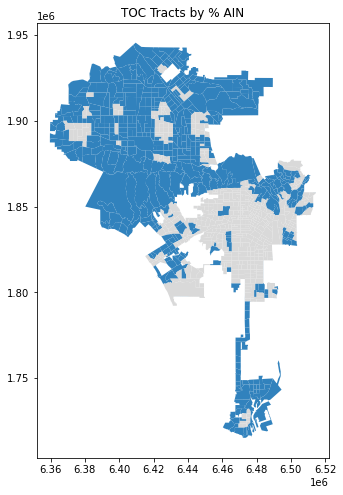

In [21]:
# By AIN
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by % AIN")
final.plot(column="toc_AIN", ax=ax, cmap = "tab20c", legend=False)

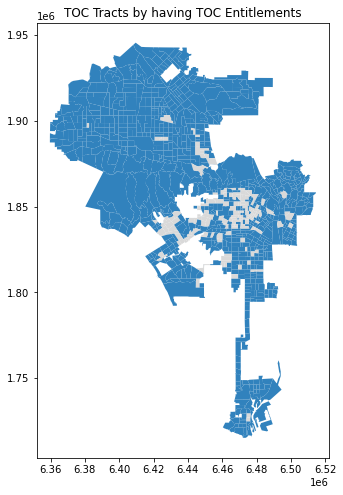

In [22]:
# By TOC ENT
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by having TOC Entitlements")
final.plot(column="toc_ENT", ax=ax, cmap = "tab20c", legend=False)

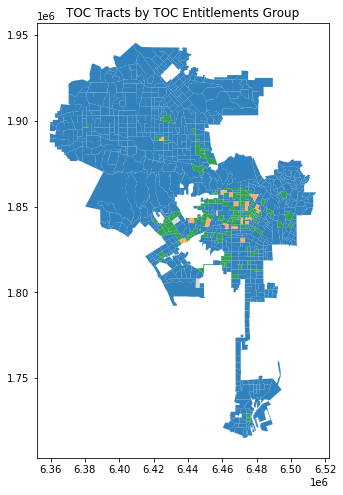

In [23]:
# By TOC ENT group
colors = {0: '#3182bd', # blue
          1: '#31a354', # green
          2: '#fdae6b', # orange
          3: '#d9d9d9'} # light gray

fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts by TOC Entitlements Group")

for ctype, data in final.groupby('toc_ENT_group'):
    
    # Define the color for each group using the dictionary
    color = colors[ctype]
    
    # Plot each group using the color defined above
    data.plot(color=color,
              ax=ax,
              label=ctype, 
              legend=True)

## C3. Tracts that switch

In [24]:
print(f"# tracts where groups differ based on cut-offs: {len(final[final.toc_area != final.toc_AIN])}")
print(final.toc_area.value_counts())
print(final.toc_AIN.value_counts())

final['different'] = final.apply(lambda row: 1 if row.toc_area != row.toc_AIN else 0, axis=1)
different = final[final.toc_area != final.toc_AIN]

# tracts where groups differ based on cut-offs: 30
0    604
1    545
Name: toc_area, dtype: int64
0    600
1    549
Name: toc_AIN, dtype: int64


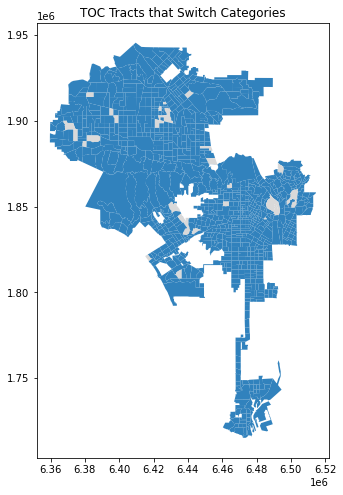

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("TOC Tracts that Switch Categories")
final.plot(column = "different", ax=ax, cmap = "tab20c", legend=False)